In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from math import comb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CosineAnnealingLR
from scipy.interpolate import splprep, splev

## CAE

**Convolutional Autoencoder (CAE) Implementation**

This section implements a Convolutional Autoencoder for:

- Learning compressed representations of fluid flow images

- Dimensionality reduction to latent space

- Image reconstruction capabilities

**The architecture includes:**

- Custom Encoder with convolutional layers

- Matching Decoder with transposed convolutions

- BCELoss for training

- Training/validation split with DataLoaders

In [12]:
class FluidFlowDataset(Dataset):
    """Custom PyTorch Dataset for fluid flow images.
    Args:
        root_dir (str): Directory containing image files
        transform (callable, optional): Optional transform to apply
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.filenames = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.transform = transform
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.filenames[idx])
        img = Image.open(img_path)
        img_array = np.array(img)  # (460, 648), 0 & 255
        
        
        img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0)  # (1, 460, 648)
        
        if self.transform:
            img_tensor = self.transform(img_tensor)
        
        return img_tensor, 0 

def get_dataloaders(root_dir, batch_size=32, val_size=0.10):
    """Creates training and validation DataLoaders for fluid flow images.
    
    Args:
        root_dir (str): Path to directory containing fluid flow images
        batch_size (int, optional): Number of samples per batch. Defaults to 32.
        val_size (float, optional): Proportion of dataset for validation (0-1). Defaults to 0.10.
        
    Returns:
        tuple: (train_loader, val_loader) where:
            - train_loader: DataLoader for training data with shuffling
            - val_loader: DataLoader for validation data without shuffling
    """
    dataset = FluidFlowDataset(root_dir=root_dir)
    
    train_data, val_data = train_test_split(
        dataset, test_size=val_size, random_state=42
    )
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [13]:
class Encoder(nn.Module):
    """Convolutional encoder network for CAE.
    Args:
        latent_dim (int): Dimension of latent space representation
    """
    def __init__(self, latent_dim=64):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # (1, 460, 648) -> (16, 230, 324)
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
            # (16, 230, 324) -> (32, 115, 162)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
            # (32, 115, 162) -> (64, 58, 81)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            
            # (64, 58, 81) -> (128, 29, 41)
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
            nn.ReLU()
        )
        
        self._calculate_fc_input(latent_dim)
    
    def _calculate_fc_input(self, latent_dim):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 460, 648)
            dummy_output = self.conv_layers(dummy_input)
            self.fc_input_dim = dummy_output.numel() // dummy_output.shape[0]
            self.fc = nn.Linear(self.fc_input_dim, latent_dim)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class Decoder(nn.Module):
    """Convolutional decoder network for CAE.
    Args:
        latent_dim (int): Dimension of latent space representation
    """
    def __init__(self, latent_dim=64):
        super().__init__()
  
        self.fc_output_dim = 128 * 29 * 41
        self.fc = nn.Linear(latent_dim, self.fc_output_dim)
        
        self.deconv_layers = nn.Sequential(
            nn.Unflatten(1, (128, 29, 41)),
            
            # (128, 29, 41) -> (64, 58, 82)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            
            # (64, 58, 82) -> (32, 116, 164)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            
            # (32, 116, 164) -> (16, 232, 328)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            
            # (16, 232, 328) -> (1, 460, 648)
            nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.fc(x)
        return self.deconv_layers(x)

class CAE(nn.Module):
    """Complete Convolutional Autoencoder architecture.
    Args:
        latent_dim (int): Dimension of latent space representation
    """
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        
        if reconstructed.shape[2:] != x.shape[2:]:
            reconstructed = F.interpolate(reconstructed, size=x.shape[2:], mode='bilinear')
        
        return reconstructed

In [14]:
def plot_reconstruction(model, dataset_path, latent_dim=64, device='cuda'):
    """Visualizes original image, latent vector and reconstructed image.
    Args:
        model (CAE): Trained autoencoder model
        dataset_path (str): Path to image dataset
        latent_dim (int): Dimension of latent space
        device (str): Computation device ('cuda' or 'cpu')
    """
    image_files = [f for f in os.listdir(dataset_path) if f.endswith('.png')]
    if not image_files:
        raise ValueError("There is no PNG images")
    
    random_image = random.choice(image_files)
    image_path = os.path.join(dataset_path, random_image)
    
    img = Image.open(image_path)
    img_array = np.array(img)  # (460, 648), 0 & 255
    img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        latent = model.encoder(img_tensor)
        reconstructed = model.decoder(latent)
    
    original_img = img_tensor[0].cpu().squeeze().numpy()  # [H, W]
    latent_vector = latent[0].cpu().numpy()               # [latent_dim]
    reconstructed_img = reconstructed[0].cpu().squeeze().numpy()  # [H, W]
    
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Original Image: {random_image}")
    plt.imshow(original_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title(f"Latent Vector ({latent_dim} dim)")
    colors = ['r' if v < 0 else 'b' for v in latent_vector]
    plt.bar(range(latent_dim), latent_vector, color=colors)
    plt.xlabel("Dimension Index")
    plt.ylabel("Value")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_img, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nAnalysis for image: {random_image}")
    print(f"Latent vector shape: {latent_vector.shape}")
    print(f"Latent vector min/mean/max: {latent_vector.min():.4f}, {latent_vector.mean():.4f}, {latent_vector.max():.4f}")
    print("\nLatent values:")
    print(np.round(latent_vector, 4))

    return original_img, latent_vector, reconstructed_img

### Training

**Training Process**

The training section demonstrates:

- 1000 epoch training loop

- Loss tracking for both training and validation sets

- Model checkpointing for best performance

- Progressive loss reduction over time

- Final achieved metrics

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
latent_dim = 128
batch_size = 64
num_epochs = 2000

root_dir = "dataset"
train_loader, val_loader = get_dataloaders(root_dir, batch_size=batch_size)

#Model 
model = CAE(latent_dim=latent_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

#Checkpoints
best_val_loss = np.inf
best_train_loss = np.inf

Device: cuda


In [16]:
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        
        optimizer.zero_grad()
        x_reconstructed = model(x)
        loss = criterion(x_reconstructed, x)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * x.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            x_reconstructed = model(x)
            loss = criterion(x_reconstructed, x)
            val_loss += loss.item() * x.size(0)
    
    val_loss /= len(val_loader.dataset)

    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(model.state_dict(), f"models_cae/best_train_cae.pth")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"models_cae/best_val_cae.pth")
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

print(f'Done!\nBest Train Loss: {best_train_loss:.5f} | Best Val Loss: {best_val_loss:.5f}')


Epoch 1/2000 | Train Loss: 0.60419 | Val Loss: 0.40746
Epoch 2/2000 | Train Loss: 0.35675 | Val Loss: 0.35152
Epoch 3/2000 | Train Loss: 0.32900 | Val Loss: 0.33941
Epoch 4/2000 | Train Loss: 0.31755 | Val Loss: 0.31596
Epoch 5/2000 | Train Loss: 0.29295 | Val Loss: 0.28583
Epoch 6/2000 | Train Loss: 0.26706 | Val Loss: 0.25611
Epoch 7/2000 | Train Loss: 0.24206 | Val Loss: 0.24005
Epoch 8/2000 | Train Loss: 0.23136 | Val Loss: 0.23184
Epoch 9/2000 | Train Loss: 0.22181 | Val Loss: 0.22341
Epoch 10/2000 | Train Loss: 0.21212 | Val Loss: 0.21182
Epoch 11/2000 | Train Loss: 0.20142 | Val Loss: 0.20231
Epoch 12/2000 | Train Loss: 0.18938 | Val Loss: 0.18659
Epoch 13/2000 | Train Loss: 0.17525 | Val Loss: 0.17258
Epoch 14/2000 | Train Loss: 0.16041 | Val Loss: 0.15702
Epoch 15/2000 | Train Loss: 0.14277 | Val Loss: 0.13741
Epoch 16/2000 | Train Loss: 0.12321 | Val Loss: 0.09404
Epoch 17/2000 | Train Loss: 0.07677 | Val Loss: 0.06150
Epoch 18/2000 | Train Loss: 0.05179 | Val Loss: 0.04564
E

KeyboardInterrupt: 

In [17]:
print(f'Done!\nBest Train Loss: {best_train_loss:.5f} | Best Val Loss: {best_val_loss:.5f}')

Done!
Best Train Loss: 0.00303 | Best Val Loss: 0.01839


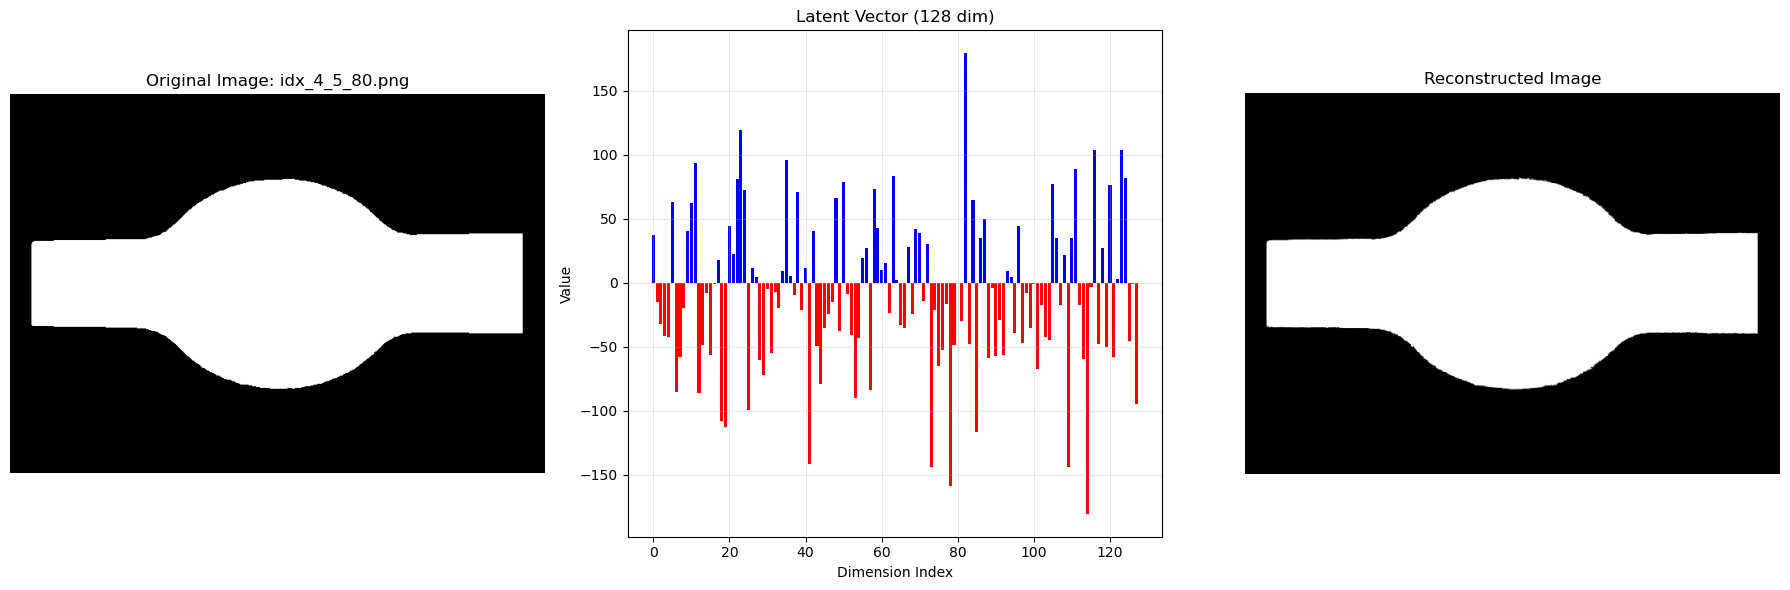


Analysis for image: idx_4_5_80.png
Latent vector shape: (128,)
Latent vector min/mean/max: -180.3688, -9.8137, 179.4194

Latent values:
[ 3.782580e+01 -1.516510e+01 -3.210820e+01 -4.110900e+01 -4.242320e+01
  6.353110e+01 -8.532000e+01 -5.804300e+01 -1.928190e+01  4.067600e+01
  6.239140e+01  9.350370e+01 -8.567860e+01 -4.889840e+01 -7.865600e+00
 -5.627790e+01 -1.099900e+00  1.772750e+01 -1.078471e+02 -1.129722e+02
  4.452550e+01  2.225240e+01  8.123040e+01  1.191384e+02  7.245090e+01
 -9.948950e+01  1.185560e+01  4.358400e+00 -6.026310e+01 -7.226860e+01
 -5.064300e+00 -5.483300e+01 -7.126200e+00 -1.955410e+01  9.645200e+00
  9.642670e+01  5.455600e+00 -9.328100e+00  7.141530e+01 -2.103180e+01
  1.179930e+01 -1.413451e+02  4.054120e+01 -4.903290e+01 -7.871680e+01
 -3.518270e+01 -2.408470e+01 -1.490510e+01  6.631380e+01 -3.795510e+01
  7.879650e+01 -8.688600e+00 -4.061270e+01 -8.973720e+01 -4.310870e+01
  1.925710e+01  2.696190e+01 -8.372010e+01  7.301380e+01  4.328270e+01
  1.040400e

In [18]:
model = CAE(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("models_cae/best_train_cae.pth"))
model.eval()

original_img, latent_vector, reconstructed_img = plot_reconstruction(model, 'dataset', latent_dim=latent_dim, device=device)

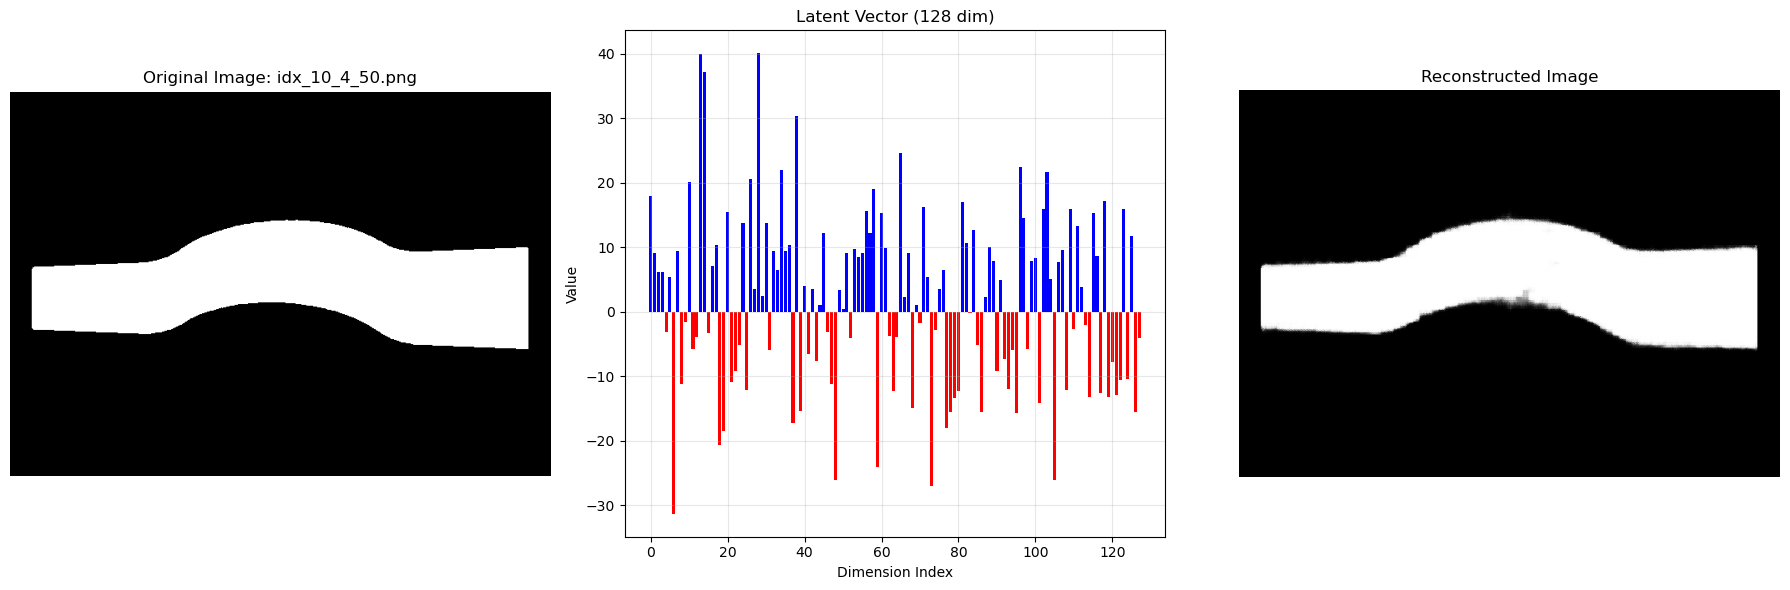


Analysis for image: idx_10_4_50.png
Latent vector shape: (128,)
Latent vector min/mean/max: -31.3175, 1.7826, 40.0250

Latent values:
[ 17.9441   9.0497   6.0895   6.1378  -3.0822   5.3981 -31.3175   9.4526
 -11.2153  -1.618   20.1515  -5.7408  -3.9308  39.9861  37.0775  -3.2491
   7.1387  10.302  -20.5969 -18.5735  15.4833 -10.8376  -9.2054  -5.1142
  13.7728 -12.1489  20.5978   3.4979  40.025    2.4602  13.7724  -5.9699
   9.4586   6.4936  21.9012   9.4693  10.3819 -17.3125  30.2852 -15.3725
   3.9819  -6.6002   3.4814  -7.6084   1.0661  12.1359  -3.1174 -11.212
 -26.0866   3.4027   0.411    9.1128  -4.1462   9.6574   8.4801   9.0263
  15.518   12.1969  19.0308 -24.1289  15.2839   9.8771  -3.7457 -12.3177
  -3.9125  24.5965   2.2003   9.0674 -14.9077   1.083   -1.8294  16.1408
   5.3589 -27.0935  -2.8323   3.4786   6.4678 -18.0226 -15.5624 -13.3748
 -12.3051  16.9504  10.5612  -0.2592  12.697   -5.2078 -15.4879   2.2211
  10.0107   7.7754  -9.1394   4.8758  -7.3453 -11.9991  -5.8912

In [35]:
model = CAE(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("models_cae/best_val_cae.pth"))
model.eval()

original_img, latent_vector, reconstructed_img = plot_reconstruction(model, 'dataset', latent_dim=latent_dim, device=device)